# Repair Project

In [330]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.autograd import grad
from torch.optim import Adam
from qadence import QNN, QuantumCircuit, feature_map, hea, chain, Z
from qadence.types import BasisSet, ReuploadScaling
from qadence import add
from qadence.draw import display
from tqdm import trange, tqdm
from scipy.integrate import solve_ivp
from qadence import RX, RY
import math
import time

### Feature maps

In [331]:
def make_feature_map(n_qubits: int, encoding: str = "cheb_tower", param: str = "x"):
    """
    Create a feature map circuit.

    Parameters
    ----------
    n_qubits : int
        Number of qubits to encode the input.
    encoding : str
        Type of encoding: currently supports "cheb_tower".
    param : str
        Name of the input parameter, e.g., "x"

    Returns
    -------
    QuantumCircuit
        A Qadence feature map circuit.
    """

    if encoding == "cheb_tower":
        #""""
        return feature_map(
            n_qubits=n_qubits,
            param=param,
            fm_type=BasisSet.CHEBYSHEV,
            reupload_scaling=ReuploadScaling.TOWER,
        )
        #"""

    raise ValueError(f"Unsupported encoding type: {encoding}")


### Ansatz

In [332]:

def make_ansatz(n_qubits: int, depth: int, ansatz_type: str = "hea"):
    """
    Create a variational ansatz circuit.

    Parameters
    ----------
    n_qubits : int
        Number of qubits in the circuit.
    depth : int
        Number of layers (rotation + entangler blocks).
    ansatz_type : str
        Type of ansatz. Currently supports "hea".

    Returns
    -------
    QuantumCircuit
        A Qadence variational circuit.
    """

    if ansatz_type == "hea":
        return hea(n_qubits=n_qubits, depth=depth)

    raise ValueError(f"Unsupported ansatz type: {ansatz_type}")


### Observable

In [333]:

def make_observable(n_qubits: int, observable_type: str = "total_magnetization"):
    """
    Generate the observable for QNN readout.

    Parameters
    ----------
    n_qubits : int
        Number of qubits in the circuit.
    observable_type : str
        Type of observable to construct. Currently supports:
        - "total_magnetization": sum of Z_i over all qubits

    Returns
    -------
    Observable (Expression)
    """
    if observable_type == "total_magnetization":
        return add(Z(i) for i in range(n_qubits))

    raise ValueError(f"Unsupported observable type: {observable_type}")


### Full QNN (circuit)

In [334]:

def make_model(fmap, ansatz, observable, n_qubits: int, input_params=["x"]):
    """
    Assemble the full QNN model.

    Parameters
    ----------
    fmap : QuantumCircuit
        Feature map circuit.
    ansatz : QuantumCircuit
        Variational ansatz circuit.
    observable : Expression
        Observable for readout.
    n_qubits : int
        Number of qubits.
    input_params : list
        Names of input variables, e.g., ["x"]

    Returns
    -------
    QNN
        Differentiable quantum neural network model.
    """
    circuit = QuantumCircuit(n_qubits, chain(fmap, ansatz))
    model = QNN(circuit=circuit, observable=observable, inputs=input_params)
    return model, circuit


### Training grid (helper) + Training loop

In [335]:

def make_training_grid(n_points: int, xmin: float, xmax: float, requires_grad=True):
    """
    Generate training input values in [xmin, xmax].

    Returns a tensor of shape (n_points, 1) with gradients enabled.
    """
    x_train = xmin + (xmax - xmin) * torch.rand(n_points, 1)
    x_train.requires_grad_(requires_grad)
    return x_train


def train_and_log(
        model,
        loss_fn,
        n_epochs=250,
        n_points=30,
        xmin=-0.99,
        xmax=0.99,
        lr=0.1,
        stop_threshold=1e-3,
        plateau_patience=10,
        min_lr=1e-7,
        clip_th=0.25,
        scheduler_eps=1e-10,
):
    """
    Train model and log losses and thetas at every epoch.

    Returns
    -------
    model : QNN
        Trained model
    history : dict
        Contains 'losses' and training config
    """

    optimizer = Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=plateau_patience, factor=0.5, eps=scheduler_eps
    )

    losses = []
    theta_log = []

    progress = trange(n_epochs, desc="Training", dynamic_ncols=True)

    for epoch in progress:
        optimizer.zero_grad()
        x_train = make_training_grid(n_points, xmin, xmax, requires_grad=True)
        loss = loss_fn(model, x_train)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_th)
        optimizer.step()

        loss_val = loss.item()
        scheduler.step(loss_val)
        current_lr = optimizer.param_groups[0]['lr']

        losses.append(loss_val)
        theta_log.append([p.detach().cpu().numpy().copy() for p in model.parameters()])

        progress.set_postfix(loss=loss_val, lr=current_lr)

        # ─── Stopping Criteria ────────────────────────────────────────────

        # (1) loss below threshold
        if loss_val < stop_threshold:
            print(f"\n Early stopping at epoch {epoch} — loss < {stop_threshold:.1e}")
            break

        # (2) learning rate too small
        if current_lr < min_lr:
            print(f"\n Stopping at epoch {epoch} — learning rate below {min_lr}")
            break

    history = {
        "losses": losses,
        "thetas": theta_log,
        "xmin": xmin,
        "xmax": xmax,
        "n_epochs": epoch + 1
    }
    return model, history


def train_and_log_regularized(
        model,
        loss_fn,
        n_epochs=250,
        n_points=30,
        xmin=-0.99,
        xmax=0.99,
        lr=0.1,
        stop_threshold=1e-3,
        plateau_patience=10,
        min_lr=1e-7,
        clip_th=0.25,
        scheduler_eps=1e-10
):
    """
    Train model with regularization-aware loss_fn(model, x, epoch). This is YOUR function.
    """
    optimizer = Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=plateau_patience, factor=0.5, eps=scheduler_eps
    )
    losses = []
    progress = trange(n_epochs, desc="Training (Regularized)", dynamic_ncols=True)

    for epoch in progress:
        optimizer.zero_grad()
        x_train = make_training_grid(n_points, xmin, xmax, requires_grad=True)

        # Pass the current epoch to the loss function
        loss = loss_fn(model, x_train, epoch)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_th)
        optimizer.step()

        loss_val = loss.item()
        scheduler.step(loss_val)
        current_lr = optimizer.param_groups[0]['lr']
        losses.append(loss_val)
        progress.set_postfix(loss=loss_val, lr=current_lr)

        if loss_val < stop_threshold:
            print(f"\\nEarly stopping at epoch {epoch} — loss < {stop_threshold:.1e}")
            break
        if current_lr < min_lr:
            print(f"\\nStopping at epoch {epoch} — learning rate below {min_lr}")
            break

    history = {"losses": losses, "n_epochs": epoch + 1}
    return model, history

### B. Differential equation with highly nontrivial dynamics

In [430]:
def make_loss_fn_case_b_floating(verbose=False):
    """
    Floating boundary version for Case B (Eq. 32).
    Enforces u(0) = 0.75 by shifting the model output.
    """
    def loss_fn(model, x):
        if verbose: print(f"  loss-fn called with batch {x.shape}")
        u_raw = model(x)

        # Floating shift to satisfy u(0) = 0.75
        x0 = torch.tensor([[0.0]], requires_grad=True)
        u0 = model(x0)
        shift = 0.75 - u0

        u = u_raw + shift

        du_dx = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            create_graph=True
        )[0]

        residual = du_dx - 4 * u + 6 * u**2 - torch.sin(50 * x) - u * torch.cos(25 * x) + 0.5
        return torch.mean(residual ** 2)

    return loss_fn

def make_regularized_loss(base_loss_fn, x_reg, u_reg, n_iter, schedule="linear", ndrop=0.3, delta=0.1):
    """
    Returns a loss function with regularization added. This is YOUR function.
    """
    def zeta(nj):
        if schedule == "linear":
            # Linear decay from 1 to 0
            return max(0.0, 1.0 - nj / n_iter)
        elif schedule == "sigmoid":
            # Sigmoid decay from 1 to 0
            return 1.0 - np.tanh((nj - ndrop * n_iter) / (delta * n_iter))
        else:
            raise ValueError(f"Unsupported schedule: {schedule}")

    def loss_fn(model, x, epoch):
        # Calculate the main loss from the PDE residual
        loss_main = base_loss_fn(model, x)

        # Calculate the regularization loss
        # Important: The regularization loss must also account for the floating shift
        with torch.no_grad():
            x0 = torch.tensor([[0.0]])
            u0 = model(x0)
            shift = 0.75 - u0.item()

        y_pred_shifted = model(x_reg) + shift
        loss_reg = torch.mean((y_pred_shifted - u_reg) ** 2)

        # Combine the two with the schedule
        total_loss = loss_main + zeta(epoch) * loss_reg
        return total_loss

    return loss_fn

def f_exact_case_b(x_tensor):
    """
    Solve Eq. (32) numerically:
    du/dx = 4u - 6u^2 + sin(50x) + u cos(25x) - 0.5
    with u(0) = 0.75
    """
    def rhs(x, u):
        return 4 * u - 6 * u**2 + np.sin(50 * x) + u * np.cos(25 * x) - 0.5

    x_eval = x_tensor.detach().cpu().numpy().flatten()
    sol = solve_ivp(rhs, [x_eval[0], x_eval[-1]], [0.75], t_eval=x_eval, method="RK45")
    return torch.tensor(sol.y[0], dtype=torch.float32)

def compute_final_solution_quality(model, x_test_base):
    # Check the dtype of the first parameter of the model.
    model_dtype = next(model.parameters()).dtype

    # Ensure all input tensors match the model's dtype.
    x_test = x_test_base.to(model_dtype)
    x0 = torch.tensor([[0.0]], dtype=model_dtype)

    with torch.no_grad():
        u_raw = model(x_test).flatten()
        u0 = model(x0)
        shift = 0.75 - u0.item()
        u_pred = u_raw + shift

    # The exact solution should also match for the final calculation.
    u_exact = f_exact_case_b(x_test).flatten().to(model_dtype)

    error = torch.mean((u_pred - u_exact)**2).item()
    return error

def compute_qnn_solution_quality_at_each_epoch(theta_log, fmap, ansatz, observable, n_qubits, x_test):
    quality = []

    # Prepare base model
    base_model, _ = make_model(fmap, ansatz, observable, n_qubits)

    for theta in theta_log:
        # Load parameters
        with torch.no_grad():
            for p, p_val in zip(base_model.parameters(), theta):
                p.copy_(torch.tensor(p_val))

        with torch.no_grad():
            # Raw prediction
            u_raw = base_model(x_test).flatten()

            # Compute shift using boundary point
            x0 = torch.tensor([[0.0]], dtype=torch.float32)
            u0 = base_model(x0)
            shift = 0.75 - u0.item()

            # Apply shift
            u_pred = u_raw + shift

        # Exact solution
        u_exact = f_exact_case_b(x_test).flatten()

        # Compute square error
        error = torch.mean((u_pred - u_exact)**2).item()
        quality.append(error)

    return quality

def compute_pinn_solution_quality_at_each_epoch(theta_history, x_test, pinn_layer_sizes):

    quality_history = []

    x_test_float = x_test.to(torch.float32)
    u_exact = f_exact_case_b(x_test_float).flatten()
    x0 = torch.tensor([[0.0]], dtype=torch.float32)

    for params_at_epoch in theta_history:
        # 1. Recreate a fresh model for this epoch's parameters
        model = PINN(pinn_layer_sizes).float()

        # 3. Load the weights for this epoch
        with torch.no_grad():
            for model_param, saved_param_val in zip(model.parameters(), params_at_epoch):
                model_param.copy_(torch.tensor(saved_param_val).to(torch.float32))

            # 4. Compute the floating boundary condition shift
            u0 = model(x0)
            shift = 0.75 - u0.item()

            # 5. Get the final prediction with the shift applied
            u_pred = model(x_test_float).flatten() + shift

        # 6. Compute and store the Mean Squared Error for this epoch
        error = torch.mean((u_pred - u_exact)**2).item()
        quality_history.append(error)

    return quality_history

def plot_losses(pinn_losses, qnn_losses, num_epochs):
    x_test = torch.linspace(0.0, num_epochs, num_epochs, dtype=torch.float32).unsqueeze(1)

    plt.semilogy(x_test.numpy().flatten(), pinn_losses, "--", label="PINN loss")
    plt.semilogy(x_test.numpy().flatten(), qnn_losses, "--", label="QNN loss")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend()
    plt.grid(True)
    plt.title("PINN and QNN Loss")
    plt.show()

def plot_qnn_vs_pinn_solution(qnn_model, pinn_model, x_min=0.0, x_max=0.99):
    # 1. Prepare test data and get the exact solution
    x_test = torch.linspace(x_min, x_max, 200).unsqueeze(1)
    y_exact = f_exact_case_b(x_test).flatten()

    # 2. Get predictions from both models, handling potential dtype issues
    with torch.no_grad():
        # --- QNN Prediction ---
        qnn_dtype = next(qnn_model.parameters()).dtype
        x_test_qnn = x_test.to(qnn_dtype)
        x0_qnn = torch.tensor([[0.0]], dtype=qnn_dtype)

        y_qnn_raw = qnn_model(x_test_qnn).flatten()
        qnn_shift = 0.75 - qnn_model(x0_qnn).item()
        y_qnn_shifted = y_qnn_raw + qnn_shift

        # --- PINN Prediction ---
        pinn_dtype = next(pinn_model.parameters()).dtype
        x_test_pinn = x_test.to(pinn_dtype)
        x0_pinn = torch.tensor([[0.0]], dtype=pinn_dtype)

        y_pinn_raw = pinn_model(x_test_pinn).flatten()
        pinn_shift = 0.75 - pinn_model(x0_pinn).item()
        y_pinn_shifted = y_pinn_raw + pinn_shift

    # 3. Plot all three curves
    #plt.figure(figsize=(10, 8))
    plt.plot(x_test.numpy(), y_exact.numpy(), label="Exact Solution", linewidth=3, color='red', alpha=0.8)
    plt.plot(x_test.numpy(), y_qnn_shifted.numpy(), label="QNN Prediction", linestyle='--', linewidth=2.5)
    plt.plot(x_test.numpy(), y_pinn_shifted.numpy(), label="PINN Prediction", linestyle=':', linewidth=2.5)

    plt.xlabel("x")
    plt.ylabel("u(x)")
    plt.title("Solution Fit: QNN vs. PINN")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_quality_per_epoch(pinn_qual, qnn_qual, num_epochs):
    x_test = torch.linspace(0.0, num_epochs, num_epochs, dtype=torch.float32).unsqueeze(1)

    plt.semilogy(x_test.numpy().flatten(), pinn_qual, "--", label="PINN quality")
    plt.semilogy(x_test.numpy().flatten(), qnn_qual, "--", label="QNN quality")
    plt.xlabel("epochs")
    plt.ylabel("quality")
    plt.legend()
    plt.grid(True)
    plt.title("PINN and QNN Quality")
    plt.show()


### 1.1 Grid search for QNN parameters

In [ ]:
# Define the parameter ranges for the grid search
qubit_range = range(2, 17, 1)
depth_range = range(4, 19, 1)

# Store results in a numpy array
results = np.zeros((len(qubit_range), len(depth_range)))

# Create a test tensor for evaluating solution quality
x_test_grid = torch.linspace(0.0, 0.99, 200).unsqueeze(1)

# Loop over all combinations of parameters
for i, n_qubits in enumerate(qubit_range):
    for j, depth in enumerate(depth_range):
        print(f"--- Training QNN with {n_qubits} qubits and depth {depth} ---")

        # 1. Build the model
        fmap = make_feature_map(n_qubits=n_qubits)
        ansatz = make_ansatz(n_qubits=n_qubits, depth=depth)
        observable = make_observable(n_qubits=n_qubits)
        model, _ = make_model(fmap, ansatz, observable, n_qubits)

        # 2. Define the loss function
        loss_fn = make_loss_fn_case_b_floating()

        # 3. Train the model
        trained_model, _ = train_and_log(
            model=model,
            loss_fn=loss_fn,
            n_epochs=250,
            n_points=20,
            xmin=0.0,
            xmax=0.99,
            lr=0.01,
            stop_threshold=1e-5,
            plateau_patience=20,
            min_lr=1e-9,
            clip_th=0.25,
            scheduler_eps=1e-9
        )

        # 4. Compute and store the final solution quality (MSE)
        solution_quality = compute_final_solution_quality(trained_model, x_test_grid)
        results[i, j] = solution_quality
        print(f"Final Solution Quality (MSE): {solution_quality:.6f}\\n")


# --- Plotting the Heatmap ---

# Use a logarithmic scale for better color differentiation if MSE values vary widely
log_results = np.log10(results)

plt.figure(figsize=(10, 8))
plt.imshow(log_results, cmap='viridis', interpolation='nearest', origin='lower',
           aspect='auto', extent=[min(depth_range)-1, max(depth_range)+1, min(qubit_range)-1, max(qubit_range)+1])

# Adding color bar and labels
cbar = plt.colorbar()
cbar.set_label('Log10 (Solution Quality - MSE)')
plt.xlabel('Ansatz Depth')
plt.ylabel('Number of Qubits')
plt.xticks(depth_range)
plt.yticks(qubit_range)
plt.title('QNN Hyperparameter Grid Search')

# Annotate the heatmap with the actual MSE values
for i, n_qubits in enumerate(qubit_range):
    for j, depth in enumerate(depth_range):
        plt.text(depth, n_qubits, f"{results[i, j]:.4f}", ha='center', va='center', color='white')

plt.show()

### 1.2 Grid search with regularization

In [ ]:
# Define the parameter ranges for the grid search
qubit_range = range(2, 17, 1)
depth_range = range(4, 19, 1)

# Store results in a numpy array
results_reg = np.zeros((len(qubit_range), len(depth_range)))

# Create a test tensor for evaluating solution quality
x_test_grid = torch.linspace(0.0, 0.99, 200).unsqueeze(1)

# --- Define Regularization Points ---
x_reg = torch.arange(0.0, 0.99, 0.025).unsqueeze(1).requires_grad_() # Regularization points (40)
u_reg = f_exact_case_b(x_reg).detach()
N_EPOCHS = 250

# Loop over all combinations of parameters
for i, n_qubits in enumerate(qubit_range):
    for j, depth in enumerate(depth_range):
        print(f"--- Training QNN with {n_qubits} qubits and depth {depth} (Regularized) ---")

        # 1. Build the model
        fmap = make_feature_map(n_qubits=n_qubits)
        ansatz = make_ansatz(n_qubits=n_qubits, depth=depth)
        observable = make_observable(n_qubits=n_qubits)
        model, _ = make_model(fmap, ansatz, observable, n_qubits)

        # 2. Define the REGULARIZED loss function
        base_loss_fn_b = make_loss_fn_case_b_floating()
        loss_fn_b_reg = make_regularized_loss(
            base_loss_fn=base_loss_fn_b,
            x_reg=x_reg,
            u_reg=u_reg,
            n_iter=N_EPOCHS,
            schedule="sigmoid", # or "linear"
            ndrop=0.4,
            delta=0.1
        )

        # 3. Train the model using the REGULARIZED training loop
        trained_model, _ = train_and_log_regularized(
            model=model,
            loss_fn=loss_fn_b_reg,
            n_epochs=N_EPOCHS,
            n_points=20,
            xmin=0.0,
            xmax=0.99,
            lr=0.01,
            stop_threshold=1e-5,
            plateau_patience=20,
            min_lr=1e-9,
            clip_th=0.25
        )

        # 4. Compute and store the final solution quality (MSE)
        solution_quality = compute_final_solution_quality(trained_model, x_test_grid)
        results_reg[i, j] = solution_quality
        print(f"Final Solution Quality (MSE): {solution_quality:.6f}\\n")


# --- Plotting the Heatmap ---
log_results_reg = np.log10(results_reg)

plt.figure(figsize=(10, 8))
plt.imshow(log_results_reg, cmap='viridis_r', interpolation='nearest', origin='lower',
           aspect='auto', extent=[min(depth_range)-1, max(depth_range)+1, min(qubit_range)-1, max(qubit_range)+1])
cbar = plt.colorbar()
cbar.set_label('Log10 (Solution Quality - MSE)')
plt.xlabel('Ansatz Depth')
plt.ylabel('Number of Qubits')
plt.xticks(depth_range)
plt.yticks(qubit_range)
plt.title('Regularized QNN Hyperparameter Grid Search')
plt.grid(False)

# Annotate the heatmap
for i, n_qubits in enumerate(qubit_range):
    for j, depth in enumerate(depth_range):
        plt.text(depth, n_qubits, f"{results_reg[i, j]:.4f}", ha='center', va='center', color='white', fontsize=6)

plt.show()


### 2.1 PINN with same number of trainable parameters as optimal (quality/complexity) QNN

In [524]:
# Define the PINN Architecture

class PINN(nn.Module):
    """
    A simple Feed-Forward Neural Network (PINN) with Tanh activation functions.
    The number of layers and neurons can be specified.
    """
    def __init__(self, layer_sizes):
        super(PINN, self).__init__()

        layers = []
        for i in range(len(layer_sizes) - 2):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            layers.append(nn.Tanh())
        # The last layer has no activation function
        layers.append(nn.Linear(layer_sizes[-2], layer_sizes[-1]))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

def count_parameters(model):
    """Helper function to count trainable parameters in a PyTorch model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [586]:
# Set Up the Comparison

n_qubits_optimal = 10
depth_optimal = 5

# Calculate the number of parameters in the optimal QNN
qnn_params_optimal = 3 * n_qubits_optimal * depth_optimal
print(f"Optimal QNN (Qubits={n_qubits_optimal}, Depth={depth_optimal}) has {qnn_params_optimal} trainable parameters.")

# Define a PINN architecture to match this parameter count.
# This may require some manual tuning of the layer sizes.
pinn_layer_sizes = [1, 10, 11, 1]
pinn_model = PINN(pinn_layer_sizes)
pinn_params_actual = count_parameters(pinn_model)
print(f"Constructed PINN with layers {pinn_layer_sizes} has {pinn_params_actual} trainable parameters.")

Optimal QNN (Qubits=10, Depth=5) has 150 trainable parameters.
Constructed PINN with layers [1, 10, 11, 1] has 153 trainable parameters.


In [587]:
# Train Both Models

# Test tensor for final quality evaluation
x_test = torch.linspace(0.0, 0.99, 200).unsqueeze(1)

# -- TRAIN THE OPTIMAL QNN (or load from grid search history) --
print("\\n--- Training Optimal QNN ---")
fmap_opt = make_feature_map(n_qubits=n_qubits_optimal)
ansatz_opt = make_ansatz(n_qubits=n_qubits_optimal, depth=depth_optimal)
observable_opt = make_observable(n_qubits=n_qubits_optimal)
qnn_model_opt, _ = make_model(fmap_opt, ansatz_opt, observable_opt, n_qubits_optimal)

loss_fn_qnn = make_loss_fn_case_b_floating()

start_time_qnn = time.time()
trained_qnn, history_qnn = train_and_log(
    model=qnn_model_opt,
    loss_fn=loss_fn_qnn,
    n_epochs=500,
    n_points=20,
    xmin=0.0,
    xmax=0.99,
    lr=0.01,
    stop_threshold=1e-5,
    plateau_patience=20,
    min_lr=1e-7,
    clip_th=0.25,
    scheduler_eps=1e-7
)
qnn_training_time = time.time() - start_time_qnn

# -- TRAIN THE PINN --
print("\\n--- Training PINN ---")
loss_fn_pinn = make_loss_fn_case_b_floating()

start_time_pinn = time.time()
trained_pinn, history_pinn = train_and_log(
    model=pinn_model,
    loss_fn=loss_fn_pinn,
    n_epochs=500,
    n_points=20,
    xmin=0.0,
    xmax=0.99,
    lr=0.01,
    stop_threshold=1e-5,
    plateau_patience=20,
    min_lr=1e-7,
    clip_th=0.25,
    scheduler_eps=1e-7
)
pinn_training_time = time.time() - start_time_pinn


\n--- Training Optimal QNN ---


Training: 100%|██████████| 500/500 [06:55<00:00,  1.20it/s, loss=0.0741, lr=1.53e-7] 


\n--- Training PINN ---


Training: 100%|██████████| 500/500 [00:01<00:00, 251.96it/s, loss=0.653, lr=1.53e-7] 


In [588]:

# Evaluate and Plot the Comparison

# Calculate final solution quality (MSE) for both models
quality_qnn = compute_final_solution_quality(trained_qnn, x_test)
quality_pinn = compute_final_solution_quality(trained_pinn, x_test)

print("\\n--- FINAL RESULTS ---")
print(f"QNN Final MSE (Quality): {quality_qnn:.6f}")
print(f"PINN Final MSE (Quality): {quality_pinn:.6f}")
print("---------------------")
print(f"QNN Avg. Time per Epoch: {qnn_training_time / len(history_qnn['losses']):.4f}s")
print(f"PINN Avg. Time per Epoch: {pinn_training_time / len(history_pinn['losses']):.4f}s")


\n--- FINAL RESULTS ---
QNN Final MSE (Quality): 0.000035
PINN Final MSE (Quality): 0.000726
---------------------
QNN Avg. Time per Epoch: 0.8315s
PINN Avg. Time per Epoch: 0.0040s


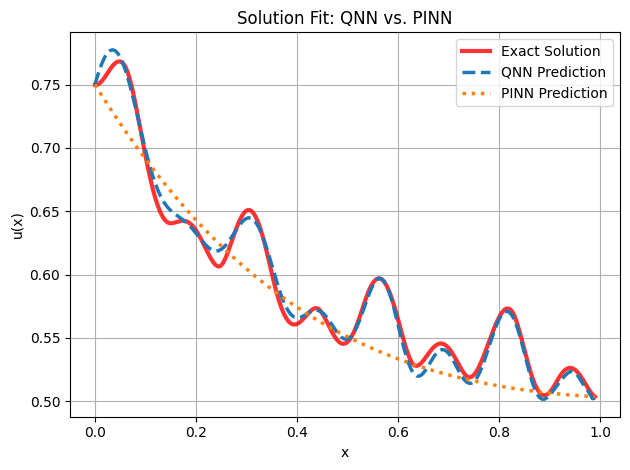

In [589]:
# Plot the solutions fit of both models
plot_qnn_vs_pinn_solution(trained_qnn, trained_pinn, x_min=0.0, x_max=0.99)

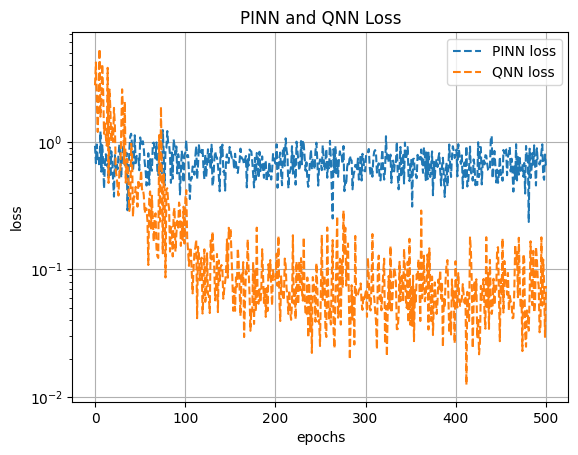

In [590]:
# Plot the losses for both models
qnn_losses = history_qnn["losses"]
pinn_losses = history_pinn["losses"]
plot_losses(pinn_losses, qnn_losses, 500)

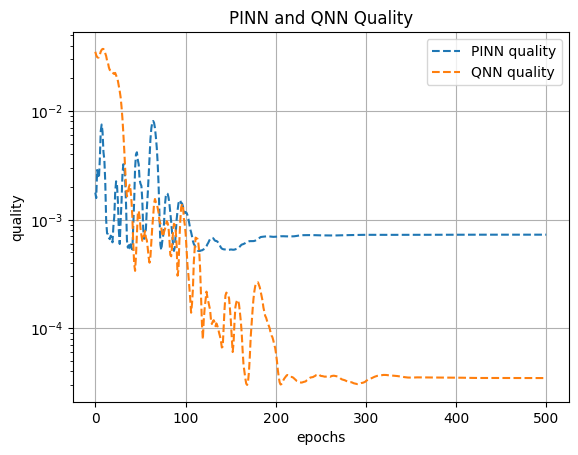

In [591]:
# Plot the quality at each epoch for the QNN vs PINN
qnn_qualities = compute_qnn_solution_quality_at_each_epoch(history_qnn["thetas"], fmap_opt, ansatz_opt, observable_opt, n_qubits_optimal, x_test)
pinn_qualities = compute_pinn_solution_quality_at_each_epoch(history_pinn["thetas"], x_test, pinn_layer_sizes)
plot_quality_per_epoch(pinn_qualities, qnn_qualities, 500)

### 2.2 Optimal QNN vs PINN (with LBFGS finetuning)

In [578]:
# Step 1: Define L-BFGS Fine-Tuning Function

def finetune_and_log_lbfgs(
        model,
        loss_fn,
        n_epochs=100,
        lr=1.0,
        plateau_patience=2,
        plateau_factor=0.85,
        min_lr=1e-7,
        n_points=150,
        xmin=0.0,
        xmax=0.99,
):

    optimizer = torch.optim.LBFGS(model.parameters(), lr=lr, max_iter=20)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=plateau_factor, patience=plateau_patience
    )

    losses = []
    theta_log = []

    # Ensure training grid matches the model's data type
    model_dtype = next(model.parameters()).dtype
    x_train = make_training_grid(n_points=n_points, xmin=xmin, xmax=xmax).to(model_dtype)

    progress = trange(n_epochs, desc="L-BFGS Fine-tuning", dynamic_ncols=True)

    for epoch in progress:
        def closure():
            """Required for L-BFGS: re-evaluates the model and returns the loss."""
            optimizer.zero_grad()
            loss = loss_fn(model, x_train)
            loss.backward()
            return loss

        loss = optimizer.step(closure)
        loss_val = loss.item()
        scheduler.step(loss_val)

        current_lr = optimizer.param_groups[0]['lr']
        losses.append(loss_val)
        theta_log.append([p.detach().cpu().numpy().copy() for p in model.parameters()])

        progress.set_postfix(loss=loss_val, lr=f"{current_lr:.1e}")

        if current_lr < min_lr:
            print(f"\\nStopping fine-tuning at epoch {epoch} — learning rate below {min_lr}")
            break

    history = {"losses": losses, "thetas": theta_log}
    return model, history

##### For 20 epochs of fine-tuning

In [576]:
# Fine-tune the QNN
print("\\--- Fine-tuning the QNN with L-BFGS ---")
loss_fn_qnn_ft = make_loss_fn_case_b_floating()
finetuned_qnn, history_qnn_ft = finetune_and_log_lbfgs(trained_qnn, loss_fn_qnn_ft, n_epochs=20, lr=0.2, plateau_patience=3, plateau_factor=0.5, min_lr=1e-8)

# -- Fine-tune the PINN --
print("\\--- Fine-tuning the PINN with L-BFGS ---")
loss_fn_pinn_ft = make_loss_fn_case_b_floating()
finetuned_pinn, history_pinn_ft = finetune_and_log_lbfgs(trained_pinn, loss_fn_pinn_ft, n_epochs=20, lr=0.2, plateau_patience=3, plateau_factor=0.5, min_lr=1e-8)

\--- Fine-tuning the QNN with L-BFGS ---


L-BFGS Fine-tuning: 100%|██████████| 20/20 [13:00<00:00, 39.03s/it, loss=7.42e-5, lr=2.0e-01] 


\--- Fine-tuning the PINN with L-BFGS ---


L-BFGS Fine-tuning: 100%|██████████| 20/20 [00:02<00:00,  9.43it/s, loss=0.215, lr=2.0e-01]


\n--- FINAL FINE-TUNED RESULTS ---
Fine-tuned QNN Final MSE (Quality): 0.000010
Fine-tuned PINN Final MSE (Quality): 0.000307


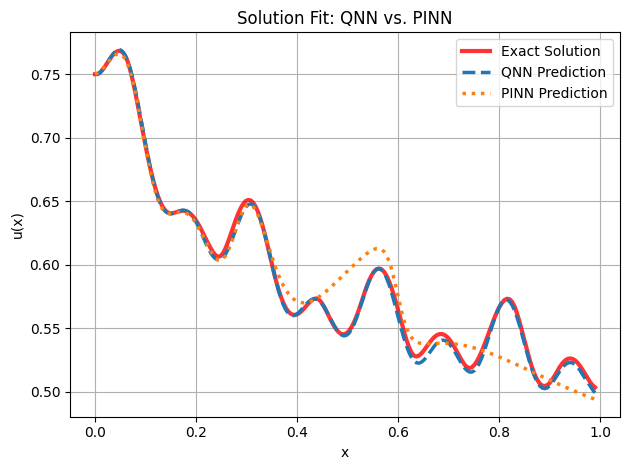

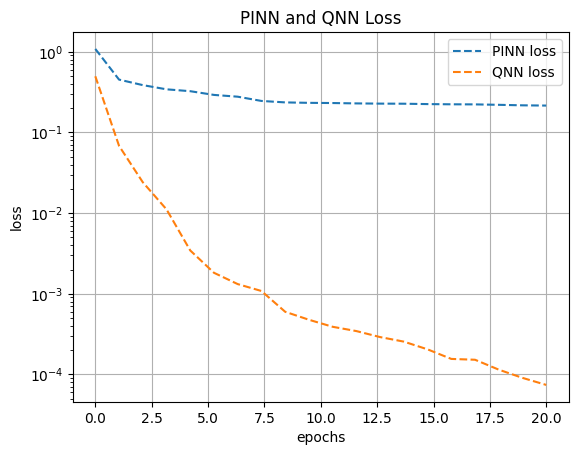

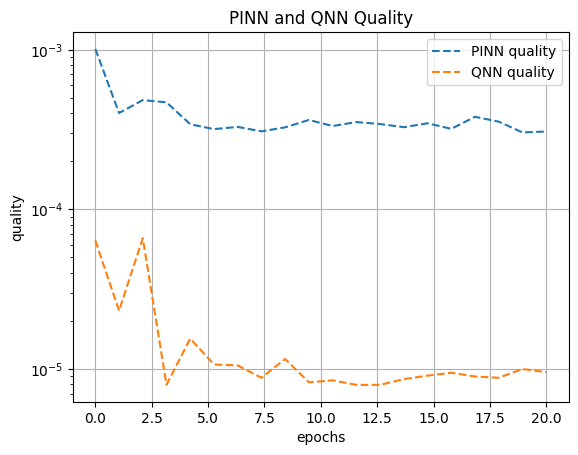

In [577]:
# Step 3: Evaluate and Plot Everything

print("\\n--- FINAL FINE-TUNED RESULTS ---")
quality_qnn_ft = compute_final_solution_quality(finetuned_qnn, x_test)
quality_pinn_ft = compute_final_solution_quality(finetuned_pinn, x_test)

print(f"Fine-tuned QNN Final MSE (Quality): {quality_qnn_ft:.6f}")
print(f"Fine-tuned PINN Final MSE (Quality): {quality_pinn_ft:.6f}")

# Plot the final solution fits
plot_qnn_vs_pinn_solution(finetuned_qnn, finetuned_pinn, x_min=0.0, x_max=0.99)

# Plot the losses during the L-BFGS fine-tuning
plot_losses(history_pinn_ft["losses"], history_qnn_ft["losses"], len(history_pinn_ft["losses"]))

# Plot the solution quality (MSE) at each epoch of the fine-tuning
qnn_qualities_ft = compute_qnn_solution_quality_at_each_epoch(history_qnn_ft["thetas"], fmap_opt, ansatz_opt, observable_opt, n_qubits_optimal, x_test)
pinn_qualities_ft = compute_pinn_solution_quality_at_each_epoch(history_pinn_ft["thetas"], x_test, pinn_layer_sizes)
plot_quality_per_epoch(pinn_qualities_ft, qnn_qualities_ft, len(pinn_qualities_ft))

##### For 100 epochs of fine-tuning

In [580]:
# Fine-tune the QNN
print("\\--- Fine-tuning the QNN with L-BFGS ---")
loss_fn_qnn_ft = make_loss_fn_case_b_floating()
finetuned_qnn, history_qnn_ft = finetune_and_log_lbfgs(trained_qnn, loss_fn_qnn_ft, n_epochs=100, lr=0.1, plateau_patience=10, plateau_factor=0.5, min_lr=1e-8)

# -- Fine-tune the PINN --
print("\\--- Fine-tuning the PINN with L-BFGS ---")
loss_fn_pinn_ft = make_loss_fn_case_b_floating()
finetuned_pinn, history_pinn_ft = finetune_and_log_lbfgs(trained_pinn, loss_fn_pinn_ft, n_epochs=100, lr=0.1, plateau_patience=10, plateau_factor=0.5, min_lr=1e-8)

\--- Fine-tuning the QNN with L-BFGS ---


L-BFGS Fine-tuning: 100%|██████████| 100/100 [17:31<00:00, 10.51s/it, loss=3.18e-5, lr=3.1e-03] 


\--- Fine-tuning the PINN with L-BFGS ---


L-BFGS Fine-tuning: 100%|██████████| 100/100 [00:11<00:00,  8.89it/s, loss=0.147, lr=1.0e-01]


\n--- FINAL FINE-TUNED RESULTS ---
Fine-tuned QNN Final MSE (Quality): 0.000010
Fine-tuned PINN Final MSE (Quality): 0.000130


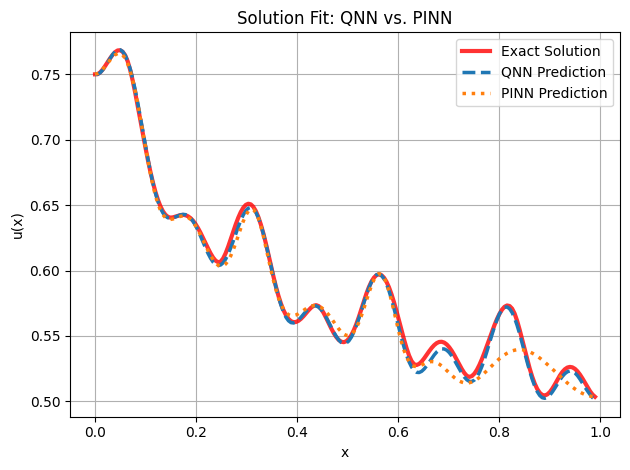

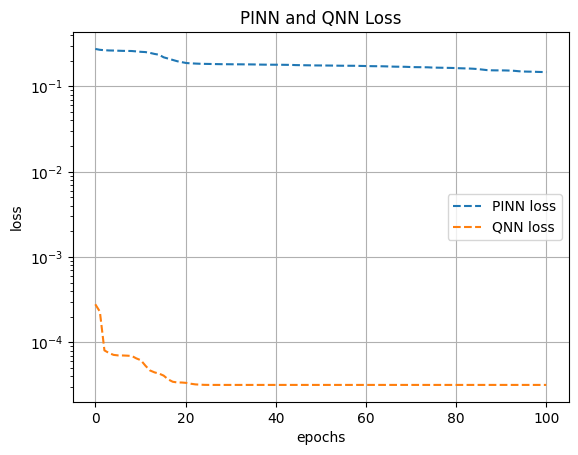

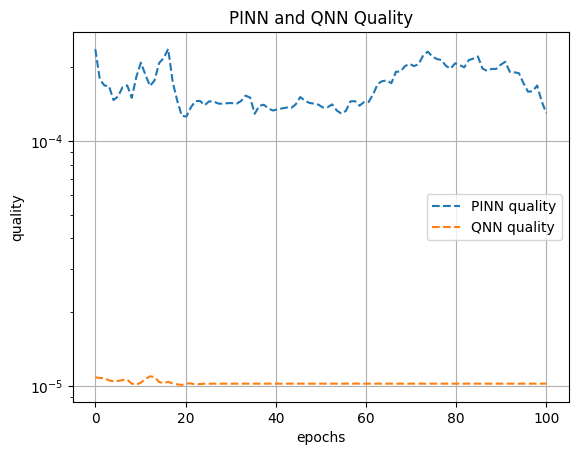

In [581]:
# Step 3: Evaluate and Plot Everything

print("\\n--- FINAL FINE-TUNED RESULTS ---")
quality_qnn_ft = compute_final_solution_quality(finetuned_qnn, x_test)
quality_pinn_ft = compute_final_solution_quality(finetuned_pinn, x_test)

print(f"Fine-tuned QNN Final MSE (Quality): {quality_qnn_ft:.6f}")
print(f"Fine-tuned PINN Final MSE (Quality): {quality_pinn_ft:.6f}")

# Plot the final solution fits
plot_qnn_vs_pinn_solution(finetuned_qnn, finetuned_pinn, x_min=0.0, x_max=0.99)

# Plot the losses during the L-BFGS fine-tuning
plot_losses(history_pinn_ft["losses"], history_qnn_ft["losses"], len(history_pinn_ft["losses"]))

# Plot the solution quality (MSE) at each epoch of the fine-tuning
qnn_qualities_ft = compute_qnn_solution_quality_at_each_epoch(history_qnn_ft["thetas"], fmap_opt, ansatz_opt, observable_opt, n_qubits_optimal, x_test)
pinn_qualities_ft = compute_pinn_solution_quality_at_each_epoch(history_pinn_ft["thetas"], x_test, pinn_layer_sizes)
plot_quality_per_epoch(pinn_qualities_ft, qnn_qualities_ft, len(pinn_qualities_ft))

##### For 250 epochs of fine-tuning

In [582]:
# Fine-tune the QNN
print("\\--- Fine-tuning the QNN with L-BFGS ---")
loss_fn_qnn_ft = make_loss_fn_case_b_floating()
finetuned_qnn, history_qnn_ft = finetune_and_log_lbfgs(trained_qnn, loss_fn_qnn_ft, n_epochs=250, lr=0.1, plateau_patience=25, plateau_factor=0.5, min_lr=1e-8)

# -- Fine-tune the PINN --
print("\\--- Fine-tuning the PINN with L-BFGS ---")
loss_fn_pinn_ft = make_loss_fn_case_b_floating()
finetuned_pinn, history_pinn_ft = finetune_and_log_lbfgs(trained_pinn, loss_fn_pinn_ft, n_epochs=250, lr=0.1, plateau_patience=25, plateau_factor=0.5, min_lr=1e-8)

\--- Fine-tuning the QNN with L-BFGS ---


L-BFGS Fine-tuning: 100%|██████████| 250/250 [13:44<00:00,  3.30s/it, loss=3.13e-5, lr=3.9e-04] 


\--- Fine-tuning the PINN with L-BFGS ---


L-BFGS Fine-tuning: 100%|██████████| 250/250 [00:26<00:00,  9.45it/s, loss=0.0255, lr=1.0e-01]


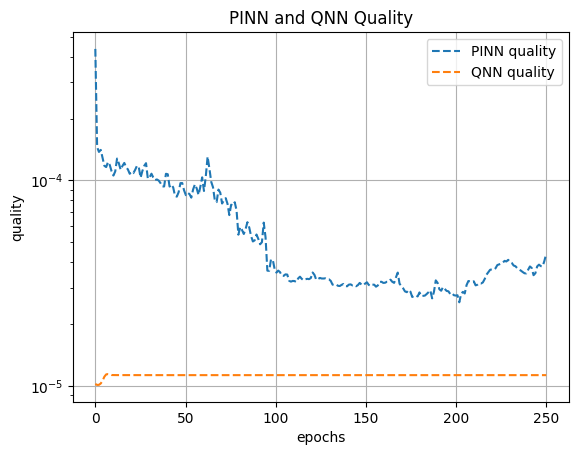

\n--- FINAL FINE-TUNED RESULTS ---
Fine-tuned QNN Final MSE (Quality): 0.000011
Fine-tuned PINN Final MSE (Quality): 0.000044


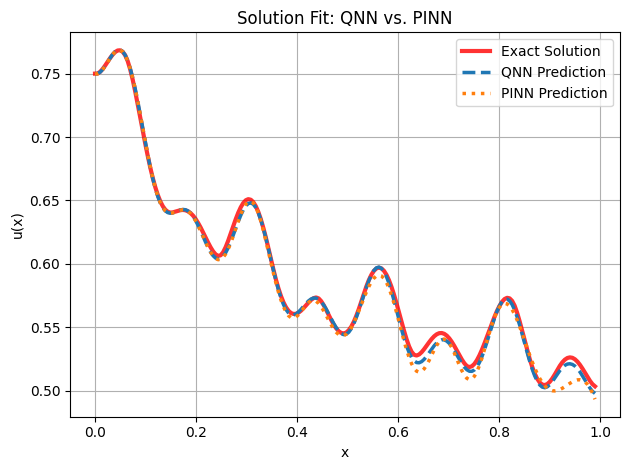

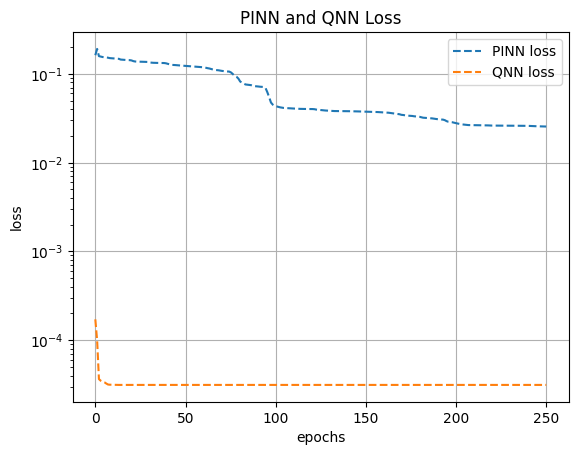

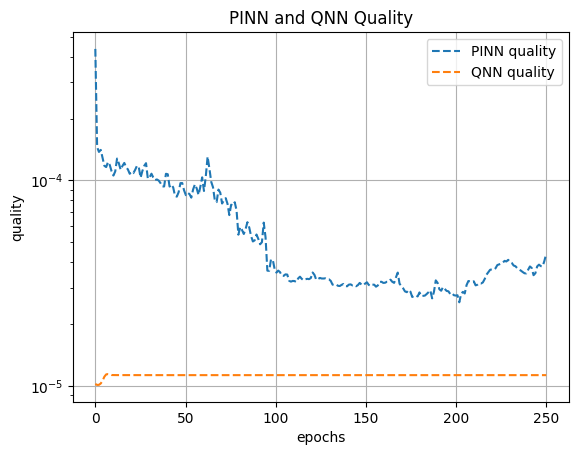

In [584]:
# Step 3: Evaluate and Plot Everything

print("\\n--- FINAL FINE-TUNED RESULTS ---")
quality_qnn_ft = compute_final_solution_quality(finetuned_qnn, x_test)
quality_pinn_ft = compute_final_solution_quality(finetuned_pinn, x_test)

print(f"Fine-tuned QNN Final MSE (Quality): {quality_qnn_ft:.6f}")
print(f"Fine-tuned PINN Final MSE (Quality): {quality_pinn_ft:.6f}")

# Plot the final solution fits
plot_qnn_vs_pinn_solution(finetuned_qnn, finetuned_pinn, x_min=0.0, x_max=0.99)

# Plot the losses during the L-BFGS fine-tuning
plot_losses(history_pinn_ft["losses"], history_qnn_ft["losses"], len(history_pinn_ft["losses"]))

# Plot the solution quality (MSE) at each epoch of the fine-tuning
qnn_qualities_ft = compute_qnn_solution_quality_at_each_epoch(history_qnn_ft["thetas"], fmap_opt, ansatz_opt, observable_opt, n_qubits_optimal, x_test)
pinn_qualities_ft = compute_pinn_solution_quality_at_each_epoch(history_pinn_ft["thetas"], x_test, pinn_layer_sizes)
plot_quality_per_epoch(pinn_qualities_ft, qnn_qualities_ft, len(pinn_qualities_ft))

### 3.1 Generalization of the QNN and PINN

- train on [0.0, 0.5] for 500 epochs
- fine-tune both on [0.0, 0.5] for 100 epochs
- test on [0.0, 0.99]

In [543]:
# Step 1: Train the QNN and PINN on [0.0, 0.5]

# -- TRAIN THE OPTIMAL QNN (or load from grid search history) --
print("\\n--- Training Optimal QNN ---")
fmap_opt = make_feature_map(n_qubits=n_qubits_optimal)
ansatz_opt = make_ansatz(n_qubits=n_qubits_optimal, depth=depth_optimal)
observable_opt = make_observable(n_qubits=n_qubits_optimal)
qnn_model_opt, _ = make_model(fmap_opt, ansatz_opt, observable_opt, n_qubits_optimal)

loss_fn_qnn = make_loss_fn_case_b_floating()

start_time_qnn = time.time()
trained_qnn, history_qnn = train_and_log(
    model=qnn_model_opt,
    loss_fn=loss_fn_qnn,
    n_epochs=500,
    n_points=20,
    xmin=0.0,
    xmax=0.5,
    lr=0.01,
    stop_threshold=1e-5,
    plateau_patience=20,
    min_lr=1e-7,
    clip_th=0.25,
    scheduler_eps=1e-7
)
qnn_training_time = time.time() - start_time_qnn

# -- TRAIN THE PINN --
print("\\n--- Training PINN ---")
pinn_layer_sizes = [1, 10, 11, 1]
pinn_model = PINN(pinn_layer_sizes)

loss_fn_pinn = make_loss_fn_case_b_floating()

start_time_pinn = time.time()
trained_pinn, history_pinn = train_and_log(
    model=pinn_model,
    loss_fn=loss_fn_pinn,
    n_epochs=500,
    n_points=20,
    xmin=0.0,
    xmax=0.5,
    lr=0.01,
    stop_threshold=1e-5,
    plateau_patience=20,
    min_lr=1e-7,
    clip_th=0.25,
    scheduler_eps=1e-7
)
pinn_training_time = time.time() - start_time_pinn


\n--- Training Optimal QNN ---


Training: 100%|██████████| 500/500 [11:30<00:00,  1.38s/it, loss=0.152, lr=1.53e-7]  


\n--- Training PINN ---


Training: 100%|██████████| 500/500 [00:03<00:00, 138.87it/s, loss=0.625, lr=1.53e-7] 


\n--- FINAL TRAINING RESULTS ---
QNN Final MSE (Quality): 0.013341
PINN Final MSE (Quality): 0.002706


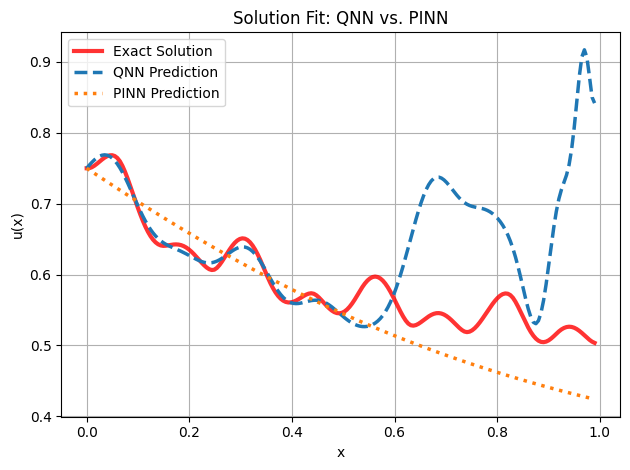

In [544]:
# Plot the solutions fit of both models
x_test = torch.linspace(0.0, 0.99, 200).unsqueeze(1)

print("\\n--- FINAL TRAINING RESULTS ---")
quality_qnn_ft = compute_final_solution_quality(trained_qnn, x_test)
quality_pinn_ft = compute_final_solution_quality(trained_pinn, x_test)

print(f"QNN Final MSE (Quality): {quality_qnn_ft:.6f}")
print(f"PINN Final MSE (Quality): {quality_pinn_ft:.6f}")

plot_qnn_vs_pinn_solution(trained_qnn, trained_pinn, x_min=0.0, x_max=0.99)

In [545]:
# Step 2: Fine-tune the QNN and PINN on [0.0, 0.5]

# Fine-tune the QNN
print("\\--- Fine-tuning the QNN with L-BFGS ---")
loss_fn_qnn_ft = make_loss_fn_case_b_floating()
finetuned_qnn, history_qnn_ft = finetune_and_log_lbfgs(trained_qnn, loss_fn_qnn_ft, n_epochs=20, lr=0.2, plateau_patience=25, plateau_factor=0.5, min_lr=1e-8,
                                                      n_points=20, xmin=0.0, xmax=0.5)

# -- Fine-tune the PINN --
print("\\--- Fine-tuning the PINN with L-BFGS ---")
loss_fn_pinn_ft = make_loss_fn_case_b_floating()
finetuned_pinn, history_pinn_ft = finetune_and_log_lbfgs(trained_pinn, loss_fn_pinn_ft, n_epochs=20, lr=0.2, plateau_patience=25, plateau_factor=0.5, min_lr=1e-8,
                                                      n_points=20, xmin=0.0, xmax=0.5)

\--- Fine-tuning the QNN with L-BFGS ---


L-BFGS Fine-tuning: 100%|██████████| 20/20 [04:09<00:00, 12.48s/it, loss=1.72e-6, lr=2.0e-01]


\--- Fine-tuning the PINN with L-BFGS ---


L-BFGS Fine-tuning: 100%|██████████| 20/20 [00:01<00:00, 11.23it/s, loss=0.0105, lr=2.0e-01]


\n--- FINAL FINE-TUNED RESULTS ---
Fine-tuned QNN Final MSE (Quality): 0.031428
Fine-tuned PINN Final MSE (Quality): 0.001773


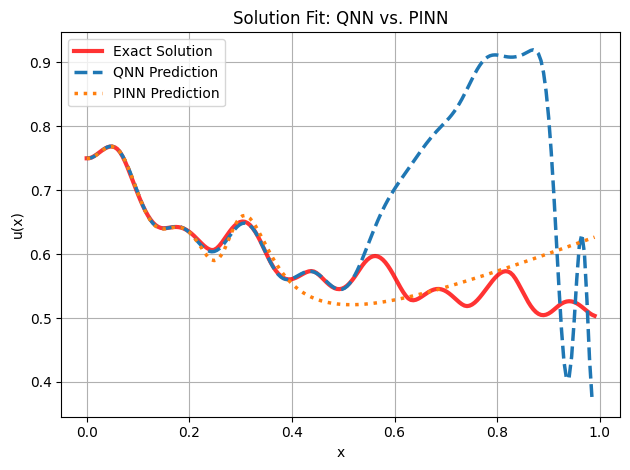

In [546]:
# Step 3: Evaluate and Plot Everything on [0.0, 0.99]

# Test tensor for final quality evaluation
x_test = torch.linspace(0.0, 0.99, 200).unsqueeze(1)

print("\\n--- FINAL FINE-TUNED RESULTS ---")
quality_qnn_ft = compute_final_solution_quality(finetuned_qnn, x_test)
quality_pinn_ft = compute_final_solution_quality(finetuned_pinn, x_test)

print(f"Fine-tuned QNN Final MSE (Quality): {quality_qnn_ft:.6f}")
print(f"Fine-tuned PINN Final MSE (Quality): {quality_pinn_ft:.6f}")

# Plot the final solution fits
plot_qnn_vs_pinn_solution(finetuned_qnn, finetuned_pinn, x_min=0.0, x_max=0.99)

### 4.1 How does the amout of training data affect the QNN and PINN?


=== Training with 5 points ===


Training: 100%|██████████| 250/250 [00:01<00:00, 212.61it/s, loss=0.351, lr=1.95e-5] 



=== Training with 10 points ===


Training: 100%|██████████| 250/250 [00:01<00:00, 195.56it/s, loss=0.446, lr=1.95e-5] 



=== Training with 15 points ===


Training: 100%|██████████| 250/250 [00:01<00:00, 190.60it/s, loss=0.657, lr=1.95e-5] 



=== Training with 20 points ===


Training: 100%|██████████| 250/250 [00:01<00:00, 141.87it/s, loss=0.852, lr=9.77e-6] 



=== Training with 25 points ===


Training: 100%|██████████| 250/250 [00:01<00:00, 186.17it/s, loss=0.543, lr=9.77e-6] 



=== Training with 30 points ===


Training: 100%|██████████| 250/250 [00:01<00:00, 206.23it/s, loss=0.64, lr=1.95e-5]  



=== Training with 35 points ===


Training: 100%|██████████| 250/250 [00:00<00:00, 275.75it/s, loss=0.891, lr=1.95e-5] 



=== Training with 40 points ===


Training: 100%|██████████| 250/250 [00:01<00:00, 223.61it/s, loss=0.829, lr=3.91e-5] 



=== Training with 45 points ===


Training: 100%|██████████| 250/250 [00:01<00:00, 237.40it/s, loss=0.651, lr=1.95e-5] 



=== Training with 50 points ===


Training: 100%|██████████| 250/250 [00:01<00:00, 166.13it/s, loss=0.651, lr=9.77e-6] 



=== Training with 55 points ===


Training: 100%|██████████| 250/250 [00:01<00:00, 239.19it/s, loss=0.789, lr=1.95e-5] 



=== Training with 60 points ===


Training: 100%|██████████| 250/250 [00:00<00:00, 258.93it/s, loss=0.757, lr=9.77e-6] 



=== Training with 65 points ===


Training: 100%|██████████| 250/250 [00:00<00:00, 256.09it/s, loss=0.512, lr=9.77e-6] 



=== Training with 70 points ===


Training: 100%|██████████| 250/250 [00:00<00:00, 271.61it/s, loss=0.605, lr=1.95e-5] 



=== Training with 75 points ===


Training: 100%|██████████| 250/250 [00:00<00:00, 270.10it/s, loss=0.761, lr=1.95e-5] 



=== Training with 80 points ===


Training: 100%|██████████| 250/250 [00:01<00:00, 236.44it/s, loss=0.614, lr=3.91e-5] 



=== Training with 85 points ===


Training: 100%|██████████| 250/250 [00:01<00:00, 241.26it/s, loss=0.719, lr=1.95e-5] 



=== Training with 90 points ===


Training: 100%|██████████| 250/250 [00:01<00:00, 186.13it/s, loss=0.562, lr=3.91e-5] 



=== Training with 95 points ===


Training: 100%|██████████| 250/250 [00:00<00:00, 255.32it/s, loss=0.589, lr=9.77e-6] 



=== Training with 100 points ===


Training: 100%|██████████| 250/250 [00:00<00:00, 250.64it/s, loss=0.669, lr=4.88e-6] 



=== Training with 105 points ===


Training: 100%|██████████| 250/250 [00:01<00:00, 214.96it/s, loss=0.718, lr=9.77e-6] 



=== Training with 110 points ===


Training: 100%|██████████| 250/250 [00:01<00:00, 211.71it/s, loss=0.687, lr=1.95e-5] 



=== Training with 115 points ===


Training: 100%|██████████| 250/250 [00:01<00:00, 233.09it/s, loss=0.595, lr=7.81e-5] 



=== Training with 120 points ===


Training: 100%|██████████| 250/250 [00:01<00:00, 209.79it/s, loss=0.681, lr=1.95e-5] 



=== Training with 125 points ===


Training: 100%|██████████| 250/250 [00:01<00:00, 233.84it/s, loss=0.761, lr=3.91e-5] 



=== Training with 130 points ===


Training: 100%|██████████| 250/250 [00:01<00:00, 214.41it/s, loss=0.694, lr=3.91e-5] 



=== Training with 135 points ===


Training: 100%|██████████| 250/250 [00:01<00:00, 132.77it/s, loss=0.711, lr=3.91e-5] 



=== Training with 140 points ===


Training: 100%|██████████| 250/250 [00:01<00:00, 198.51it/s, loss=0.749, lr=9.77e-6] 



=== Training with 145 points ===


Training: 100%|██████████| 250/250 [00:01<00:00, 189.81it/s, loss=0.589, lr=3.91e-5] 



=== Training with 150 points ===


Training: 100%|██████████| 250/250 [00:01<00:00, 186.58it/s, loss=0.607, lr=9.77e-6] 


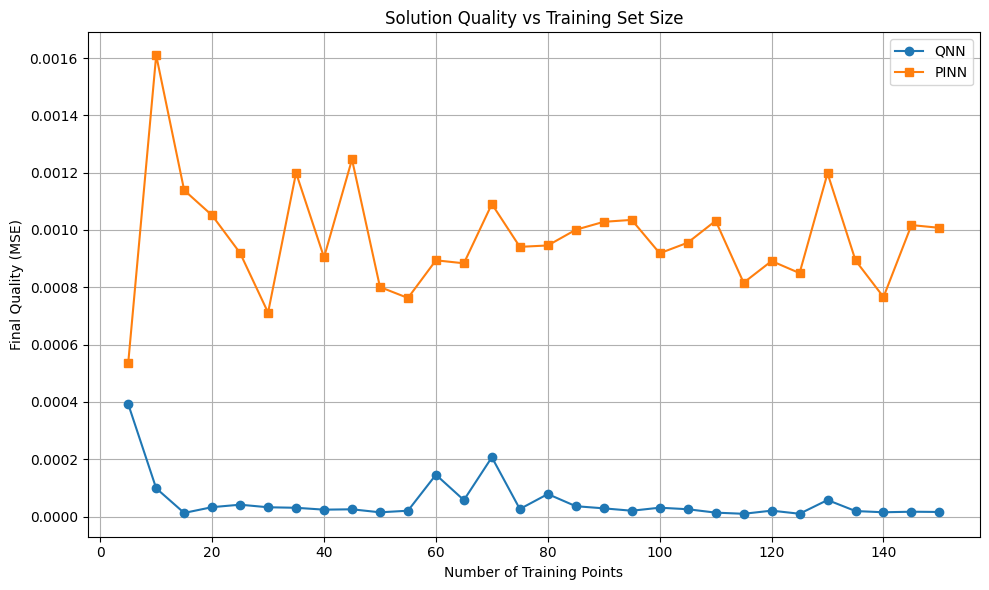

In [592]:
# Settings
n_qubits_optimal = 10
depth_optimal = 5
pinn_layer_sizes = [1, 10, 11, 1]
x_test = torch.linspace(0.0, 0.99, 200).unsqueeze(1)

# Ranges and results
n_points_range = list(range(5, 155, 5))
qnn_qualities = []
pinn_qualities = []

# Loop over training set sizes
for n_points in n_points_range:
    print(f"\n=== Training with {n_points} points ===")

    # --- Train QNN ---
    fmap = make_feature_map(n_qubits=n_qubits_optimal)
    ansatz = make_ansatz(n_qubits=n_qubits_optimal, depth=depth_optimal)
    observable = make_observable(n_qubits=n_qubits_optimal)
    qnn_model, _ = make_model(fmap, ansatz, observable, n_qubits_optimal)
    loss_fn_qnn = make_loss_fn_case_b_floating()

    trained_qnn, _ = train_and_log(
        model=qnn_model,
        loss_fn=loss_fn_qnn,
        n_epochs=250,
        n_points=n_points,
        xmin=0.0,
        xmax=0.99,
        lr=0.01,
        stop_threshold=1e-5,
        plateau_patience=20,
        min_lr=1e-7,
        clip_th=0.25,
        scheduler_eps=1e-7
    )
    qnn_mse = compute_final_solution_quality(trained_qnn, x_test)
    qnn_qualities.append(qnn_mse)

    # --- Train PINN ---
    pinn_model = PINN(pinn_layer_sizes)
    loss_fn_pinn = make_loss_fn_case_b_floating()

    trained_pinn, _ = train_and_log(
        model=pinn_model,
        loss_fn=loss_fn_pinn,
        n_epochs=250,
        n_points=n_points,
        xmin=0.0,
        xmax=0.99,
        lr=0.01,
        stop_threshold=1e-5,
        plateau_patience=20,
        min_lr=1e-7,
        clip_th=0.25,
        scheduler_eps=1e-7
    )
    pinn_mse = compute_final_solution_quality(trained_pinn, x_test)
    pinn_qualities.append(pinn_mse)


plt.figure(figsize=(10, 6))
plt.plot(n_points_range, qnn_qualities, label="QNN", marker="o")
plt.plot(n_points_range, pinn_qualities, label="PINN", marker="s")
plt.xlabel("Number of Training Points")
plt.ylabel("Final Quality (MSE)")
plt.title("Solution Quality vs Training Set Size")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 5.1 Noisy QNN + mitigation

In [349]:
from qadence.noise import NoiseHandler
from qadence.types import NoiseProtocol, ReadOutOptimization
from qadence.mitigations import Mitigations

# Convert bitstrings to total Z expectation
def compute_total_z_expectation(samples):
    return np.mean([sum(1 if b == '0' else -1 for b in sample) for sample in samples])

# MSE
def compute_mse(preds, targets):
    return ((preds - targets) ** 2).mean()

# Sample one x at a time (to avoid mitigation issues)
def run_sampling(qnn, x_points, noise=None, mitigation=None, n_shots=10000):
    results = []
    for x in x_points:
        x_val = x.unsqueeze(0)
        try:
            samples = qnn.sample(
                values={"x": x_val},
                noise=noise,
                mitigation=mitigation,
                n_shots=n_shots
            )
            z_exp = compute_total_z_expectation(samples[0])
            results.append(z_exp)
        except Exception as e:
            print(f"Sampling error at x={x_val.item():.3f}: {e}")
            results.append(float("nan"))
    return torch.tensor(results, dtype=torch.float32)

# Noise + mitigation
noise = NoiseHandler(
    protocol=NoiseProtocol.READOUT.INDEPENDENT,
    options={"error_probability": 0.05, "seed": 7}
)

mitigation = Mitigations(
    protocol="readout",
    options={"optimization_type": ReadOutOptimization.CONSTRAINED}  # CONSTRAINED or MLE
)

x_test = torch.linspace(0.0, 0.99, 200).unsqueeze(1)

clean_qnn = finetuned_qnn
noisy_qnn = finetuned_qnn
mitig_qnn = finetuned_qnn

# Run inference
print("Sampling clean...")
y_clean = run_sampling(clean_qnn, x_test)

print("Sampling noisy...")
y_noisy = run_sampling(noisy_qnn, x_test, noise=noise)

print("Sampling mitigated...")
y_mitig = run_sampling(mitig_qnn, x_test, noise=noise, mitigation=mitigation)

# Ground truth
u_exact = f_exact_case_b(x_test).flatten().to(dtype=torch.float32)

# MSE
mse_clean = compute_mse(y_clean, u_exact)
mse_noisy = compute_mse(y_noisy, u_exact)
mse_mitig = compute_mse(y_mitig, u_exact)

# Report
print(f"\nMSE clean  : {mse_clean:.3e}")
print(f"MSE noisy    : {mse_noisy:.3e}")
print(f"MSE mitigated: {mse_mitig:.3e}")


Sampling clean...
Sampling noisy...
Sampling mitigated...


WARNING 2025-07-05 21:40:11 - qadence.backends.pyqtorch.backend: Mitigation protocol is deprecated. Use qadence-protocols instead.
WARNING 2025-07-05 21:40:20 - qadence.backends.pyqtorch.backend: Mitigation protocol is deprecated. Use qadence-protocols instead.
WARNING 2025-07-05 21:40:27 - qadence.backends.pyqtorch.backend: Mitigation protocol is deprecated. Use qadence-protocols instead.
WARNING 2025-07-05 21:40:34 - qadence.backends.pyqtorch.backend: Mitigation protocol is deprecated. Use qadence-protocols instead.
WARNING 2025-07-05 21:40:42 - qadence.backends.pyqtorch.backend: Mitigation protocol is deprecated. Use qadence-protocols instead.
WARNING 2025-07-05 21:40:50 - qadence.backends.pyqtorch.backend: Mitigation protocol is deprecated. Use qadence-protocols instead.
WARNING 2025-07-05 21:40:57 - qadence.backends.pyqtorch.backend: Mitigation protocol is deprecated. Use qadence-protocols instead.
WARNING 2025-07-05 21:41:05 - qadence.backends.pyqtorch.backend: Mitigation protoco


MSE clean  : 3.579e-01
MSE noisy    : 3.579e-01
MSE mitigated: 4.618e-01
